Predicting Depression Levels Based on Reddit Content using NLP approach

Problem Statement: Can we accurately predict the level or likelihood of depression in a user based on the content they post across different subreddits?

Hypothesis: The language used by individuals in mental health-related subreddits (such as "Depression" and "SuicideWatch") contains specific linguistic markers that can be used to predict depressive symptoms.

Experiment Design: Use natural language processing (NLP) techniques to extract features from the Reddit posts, such as sentiment, linguistic patterns, word frequency, and topic modeling. Train a machine learning model (e.g., logistic regression, random forest, or deep learning model) to predict whether a post is indicative of depression.

Evaluation: Evaluate the model's accuracy using precision, recall, F1 score, and ROC-AUC metrics. Conduct a qualitative analysis of the most important features to understand which language patterns are most predictive.

Connections to the Humanities:
Linguistic Analysis: In the humanities, studying language is a key focus. By analyzing the language used in Reddit posts, you can explore how cultural and social factors shape the ways people express mental health issues. For example, language patterns can reveal how different groups articulate their experiences of depression, the metaphors they use, or the influence of cultural stigma on discussing mental health.

Cultural Studies: The expression of mental health issues online can be linked to cultural studies by examining how digital communities create shared meanings and norms around mental health. You could explore how different subreddits serve as cultural spaces where people come together to discuss their struggles, share advice, and form communities, thus producing and reproducing cultural attitudes toward mental health.

Connections to Cultural Production:
Digital Spaces as Sites of Cultural Production: Online forums like Reddit can be considered spaces where cultural production occurs. These spaces produce cultural narratives about mental health through shared stories, coping mechanisms, and expressions of emotional experiences. By predicting depression from posts, you are engaging with the content produced by users, which reflects broader cultural attitudes and discourses on mental health.

Role of Media in Shaping Cultural Norms: You could frame the project as an exploration of how online platforms influence cultural understandings of depression and mental health. This involves analyzing how language and content around mental health are shaped by the digital medium and how these cultural products (posts, stories, discussions) impact individuals' perceptions of mental well-being.

Potential Hypothesis with a Cultural Production Angle:
Hypothesis: "The language used in digital communities dedicated to mental health reflects broader cultural narratives about depression, and shifts in language patterns may indicate changes in cultural attitudes toward mental health over time."

Depression Definition:
Depression is a mood disorder that causes a persistent feeling of sadness and loss of interest [1].

In our Reddit Dataset from https://www.kaggle.com/datasets/rishabhkausish/reddit-depression-dataset/data, the reddit posts are classified as depression based solely on textual evidence and not clinical diagnosis. Identifying whethere the user is depressed based on their social media post is challenging because there is this question of "Who are you to say that this person is depressed?" Many people are skeptical of using AI to diagnose depression. I want to be clear that this project is not to be used for self-diagnosis, but rather to see the potential of NLP to classify depression with attention.


How a humanist use text?

- Identify similarity and differences between reddit posts 
- Track changes in content & style of posts over time
- compare text from different subreddits
- correlate posts with social events

In [1]:
#Imported modules
import pandas as pd
import matplotlib.pyplot as plt
from transformers import BertTokenizerFast, BertForSequenceClassification, AdamW

import torch 
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR

import os
from tqdm import tqdm

from torch.optim import AdamW  # Using PyTorch's AdamW
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.amp import GradScaler, autocast


In [ ]:
df = pd.read_csv("reddit_depression_dataset.csv")

df.to_pickle("dataframe.pkl")
df.sample(5)
# df = pd.read_pickle("dataframe.pkl")


Data Card:

Subreddit: The subreddit where the post was shared

Title: The title provided by the user for the post

Body: The content of the post written by the user

Upvotes: The number of upvotes the post received

Created UTC : The time the post was created, given in UTC epoch time

Number of Comments: The total count of comments on the post

Label: The category assigned to the post, where 0 indicates normal and 1 indicates depressed (Target)

In [3]:
df = df.rename(columns={"body": "content"}).drop("Unnamed: 0", axis = 1)
#axis = 1 is column
df.columns


Index(['subreddit', 'title', 'content', 'upvotes', 'created_utc',
       'num_comments', 'label'],
      dtype='object')

In [4]:
df['subreddit'].unique()

array(['DeepThoughts', 'teenagers', '15', '6', '30', '5', '12', '16', nan,
       '7', '4', '61', '10', '9', '8', '107', '11', 'happy',
       'SuicideWatch', '1402326041', 'depression', '31', '101', '27',
       '47'], dtype=object)

In [5]:
df['label'].unique()

array([ 0., nan,  1.])

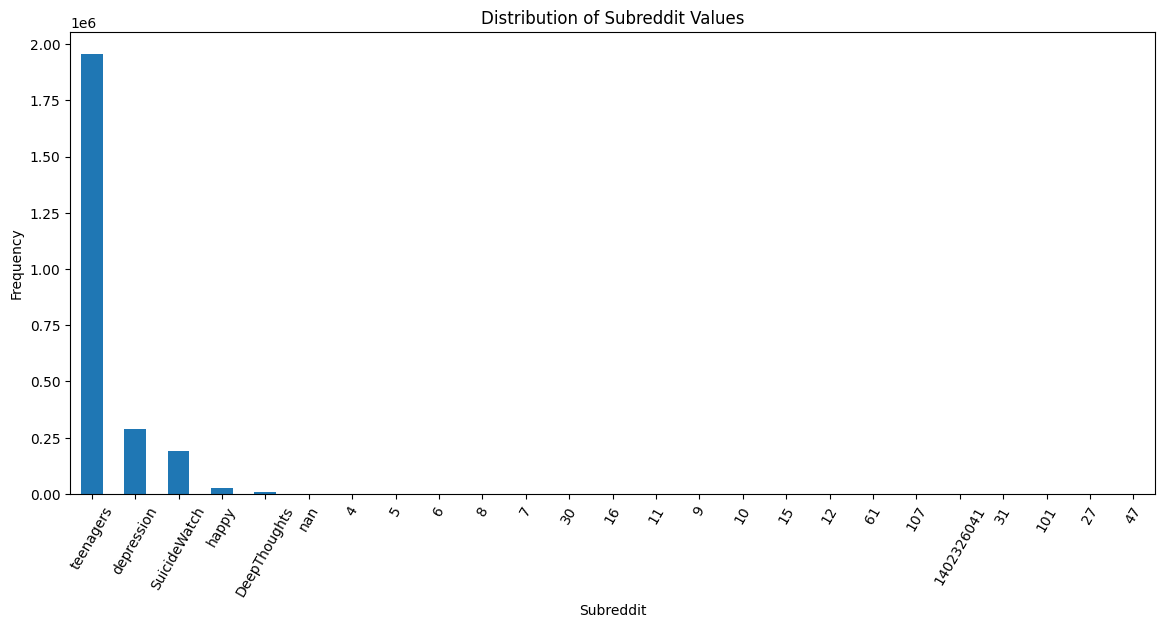

In [6]:
# Count the occurrences of each unique value
subreddit_counts = df['subreddit'].value_counts(dropna=False)

# Plot the distribution
plt.figure(figsize=(14, 6))
subreddit_counts.plot(kind='bar')
plt.title('Distribution of Subreddit Values')
plt.xlabel('Subreddit')
plt.ylabel('Frequency')
plt.xticks(rotation=60) 
plt.show()

Observe that the dataset contains Reddit posts from 5 subreddits: DeepThoughts, teenagers, SuicideWatch, depression, and happy.

My prior is that we will most likely find more depression posts in SuicideWatch and depression. Happy will contain less language that relates to depression. I think posts from DeepThoughts and teenagers can expose languages that can be found in depressed posts.

In [7]:
# subreddits to keep
subreddits_to_keep = ['DeepThoughts', 'teenagers', 'SuicideWatch', 'depression', 'happy']

# Filter the DataFrame
filtered_df = df[df['subreddit'].isin(subreddits_to_keep) ]

# Reset index (optional)
filtered_df.reset_index(drop=True, inplace=True)

# Filter out rows with NaN labels
filtered_df = filtered_df[filtered_df['label'].notna()]

# Reset index (optional)
filtered_df.reset_index(drop=True, inplace=True)

In [8]:
print(f'Number of entries in the dataset: {len(filtered_df)}')
print(f'Number of entries in each columns: \n{filtered_df.count()}')


Number of entries in the dataset: 2470672
Number of entries in each columns: 
subreddit       2470672
title           2470669
content         2009643
upvotes         2470672
created_utc     2470672
num_comments    2356801
label           2470672
dtype: int64


Some content are none. Instead of filtering data entries with "no content" we want to replace the data with a dummy content value like "no content" because many Reddit users expresses ideas in their post through the title with no content body.

In [9]:
# Filter rows where 'label' is 1
label_1_df = filtered_df[filtered_df['label'] == 1]

# Sample 10 rows from the filtered DataFrame
label_1_sample = label_1_df.sample(10)

# Get the 'content' column from the sampled rows
sampled_content = label_1_sample['content']

# Display one of the content values (for example, the first one)
print(sampled_content.iloc[3])



I just keep getting worse and worse. I just wish I was dead every single day. I shouldn’t even be here. All I do is ruin everyone else’s life.


In [10]:
# Make a copy of the filtered DataFrame to avoid chained assignment issues
filtered_df = filtered_df.copy()

# Replace NaN values using .loc[]
filtered_df.loc[:, 'title'] = filtered_df['title'].fillna('')
filtered_df.loc[:, 'content'] = filtered_df['content'].fillna('')

# Create the 'title_and_body' column
filtered_df.loc[:, 'title_and_body'] = filtered_df['title'] + ': ' + filtered_df['content']
display(filtered_df[['subreddit', 'title_and_body', 'label']])


,subreddit,title_and_body,label
0,DeepThoughts,Deep thoughts underdog: Only when we start con...,0.0
1,DeepThoughts,"I like this sub, there's only two posts yet I ...",0.0
2,DeepThoughts,Rebirth!: Hello. \nI am the new guy in charge ...,0.0
3,DeepThoughts,"""I want to be like water. I want to slip throu...",0.0
4,DeepThoughts,Who am I?: You could take any one cell in my b...,0.0
...,...,...,...
2470667,depression,Alone as usual: I just argued with my mom an h...,1.0
2470668,depression,Help needed urgently!: OK basically non of my ...,1.0
2470669,depression,I know what your thinking: Don't do It. Not to...,1.0
2470670,depression,how do I stop having such a cynical view on ma...,1.0


In [12]:
filtered_df['label'].unique()
filtered_df.to_pickle("dataframe.pkl")

In [2]:
filtered_df = pd.read_pickle("dataframe.pkl")


In [15]:
filtered_df.count()

subreddit         2470672
title             2470672
content           2470672
upvotes           2470672
created_utc       2470672
num_comments      2356801
label             2470672
title_and_body    2470672
dtype: int64

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [17]:
# Initialize tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Check if CUDA is available and set device to GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Parameters
chunk_size = 3000  # Adjust based on memory capacity
save_dir = "tokenized_chunks"  # Directory to store tokenized chunks
os.makedirs(save_dir, exist_ok=True)

# Example labels array (replace with actual labels)
labels = filtered_df['label'].tolist()

# Tokenize and save each chunk with GPU storage
for i, start in enumerate(tqdm(range(0, len(filtered_df), chunk_size), desc="Tokenizing and Saving Chunks")):
    chunk = filtered_df['title_and_body'].iloc[start:start + chunk_size].tolist()
    chunk_inputs = tokenizer(chunk, padding=True, truncation=True, max_length=128, return_tensors="pt")
    
    # Move tensors to GPU
    chunk_inputs['input_ids'] = chunk_inputs['input_ids'].to(device)
    chunk_inputs['attention_mask'] = chunk_inputs['attention_mask'].to(device)

    # Save each chunk to file (if needed, this can be adjusted to keep in memory for current use only)
    torch.save(chunk_inputs['input_ids'], os.path.join(save_dir, f'input_ids_chunk_{i}.pt'))
    torch.save(chunk_inputs['attention_mask'], os.path.join(save_dir, f'attention_mask_chunk_{i}.pt'))

print("Tokenization and saving complete for all chunks.")



Using device: cuda


Tokenizing and Saving Chunks: 100%|██████████| 824/824 [02:45<00:00,  4.99it/s]

Tokenization and saving complete for all chunks.


In [18]:
# Directory where the tokenized chunks are saved
save_dir = "tokenized_chunks"

# Lists to collect input_ids and attention_mask tensors
input_ids_list = []
attention_mask_list = []

# Find the number of chunks (assuming chunks are saved with a naming convention "input_ids_chunk_{i}.pt")
num_chunks = len([f for f in os.listdir(save_dir) if f.startswith("input_ids_chunk")])

# Load and concatenate each chunk with progress tracking
for i in tqdm(range(num_chunks), desc="Loading and Concatenating Chunks"):
    # Load each chunk from the directory
    input_ids = torch.load(os.path.join(save_dir, f'input_ids_chunk_{i}.pt'))
    attention_mask = torch.load(os.path.join(save_dir, f'attention_mask_chunk_{i}.pt'))

    # Append to the lists
    input_ids_list.append(input_ids)
    attention_mask_list.append(attention_mask)

# Concatenate all chunks into final tensors
input_ids = torch.cat(input_ids_list, dim=0)
attention_mask = torch.cat(attention_mask_list, dim=0)

print("Concatenation complete.")
print("Concatenated input_ids shape:", input_ids.shape)
print("Concatenated attention_mask shape:", attention_mask.shape)


Loading and Concatenating Chunks:   0%|          | 0/824 [00:00<?, ?it/s]C:\Users\Benja\AppData\Local\Temp\ipykernel_26328\1291536786.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experiment

Concatenation complete.
Concatenated input_ids shape: torch.Size([2470672, 128])
Concatenated attention_mask shape: torch.Size([2470672, 128])


In [19]:
# Path to save the concatenated tensors
output_dir = "final_tokenized_data"
os.makedirs(output_dir, exist_ok=True)

# Save the concatenated tensors
torch.save(input_ids, os.path.join(output_dir, "input_ids.pt"))
torch.save(attention_mask, os.path.join(output_dir, "attention_mask.pt"))

print("Concatenated tensors saved successfully.")


Concatenated tensors saved successfully.


In [3]:
# # Load the concatenated tensors
output_dir = "final_tokenized_data"

input_ids = torch.load(os.path.join(output_dir, "input_ids.pt"))
attention_mask = torch.load(os.path.join(output_dir, "attention_mask.pt"))

print("Loaded concatenated tensors.")
print("input_ids shape:", input_ids.shape)
print("attention_mask shape:", attention_mask.shape)


C:\Users\Benja\AppData\Local\Temp\ipykernel_15992\3361326535.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  input_ids = torch.load(os.path.join(output_dir, "input_ids.p

Loaded concatenated tensors.
input_ids shape: torch.Size([2470672, 128])
attention_mask shape: torch.Size([2470672, 128])


Alt


In [21]:
# tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# inputs = tokenizer(filtered_df['title_and_body'].tolist(), padding=True, truncation=True, max_length = 256, return_tensors="pt")
# labels = filtered_df['label']
# labels


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [10]:
import torch 
from torch.utils.data import Dataset, DataLoader

class DepressionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx]).clone().detach()
        return item
    
labels = filtered_df['label'].tolist()

    
inputs = {
    'input_ids': input_ids,
    'attention_mask': attention_mask
}
dataset = DepressionDataset(inputs, labels)

dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle = True) # was 16
val_dataloader = DataLoader(val_dataset, batch_size = 32, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle =True)





In [4]:
# only 5 % of the dataset to make a mini model.

class DepressionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        # Return a dictionary containing the input encodings and the label
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx]).clone().detach()
        return item

# Assuming `filtered_df` has already been defined with columns 'title_and_body' and 'label'
labels = filtered_df['label'].tolist()

# Assuming `input_ids` and `attention_mask` have been defined in a previous step
inputs = {
    'input_ids': input_ids,
    'attention_mask': attention_mask
}

# Create the full dataset
dataset = DepressionDataset(inputs, labels)

# Calculate the dataset size for the 5% subset
dataset_size = len(dataset)
subset_size = int(0.01 * dataset_size)

# Split the dataset into a subset and discard the rest
subset_dataset, _ = random_split(dataset, [subset_size, dataset_size - subset_size])

# Split the 5% subset into train, validation, and test sets
train_size = int(0.8 * subset_size)
val_size = int(0.1 * subset_size)
test_size = subset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(subset_dataset, [train_size, val_size, test_size])

# Create DataLoaders for each set
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")


Training set size: 19764
Validation set size: 2470
Test set size: 2472


In [23]:
print(len(labels))
print(len(input_ids))


2470672
2470672


In [ ]:
# Helper function to save checkpoints
def save_checkpoint(epoch, model, optimizer, scheduler, scaler, checkpoint_dir="checkpoints"):
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}.pt")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'scaler_state_dict': scaler.state_dict() if scaler else None,
    }, checkpoint_path)
    print(f"Checkpoint saved at {checkpoint_path}")

# Helper function to load checkpoints
def load_checkpoint(checkpoint_path, model, optimizer, scheduler, scaler):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    if scaler and checkpoint['scaler_state_dict']:
        scaler.load_state_dict(checkpoint['scaler_state_dict'])
    print(f"Checkpoint loaded from {checkpoint_path}")
    return checkpoint['epoch'] + 1  # Start from the next epoch

In [24]:
# Enable CUDA synchronization for accurate error traces
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Load a pre-trained BERT model with a classification head
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", torch_dtype=torch.float16, num_labels = 2)
model = model.to('cuda')

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)  # Decreases LR by 0.1 every epoch

# Initialize GradScaler for mixed precision
scaler = GradScaler()

# Ensure all model parameters are in float32 to prevent FP16 gradient errors
model = model.to(torch.float32).to('cuda')

def train(model, train_dataloader, val_dataloader, optimizer, scheduler, scaler, epochs=3, start_epoch=0, checkpoint_dir="checkpoints"):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        
        # Training phase
        model.train()  # Set model to training mode
        batch_train_losses = []
        
        # Initialize progress bar for training
        train_progress = tqdm(train_dataloader, desc="Training", leave=False)
        
        for batch in train_progress:
            input_ids = batch['input_ids'].to('cuda')
            attention_mask = batch['attention_mask'].to('cuda')
            labels = batch['labels'].to('cuda').long()

            optimizer.zero_grad()  # Clear previous gradients

            # Mixed precision forward pass
            with autocast(device_type="cuda"):
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                batch_train_losses.append(loss.item())  # Save batch loss
            # Backpropagation with scaled loss
            scaler.scale(loss).backward()

            # Unscales gradients before the optimizer step to handle NaNs/Infs
            scaler.unscale_(optimizer)

            # Check for NaN or Inf in gradients
            found_inf = False
            for param in model.parameters():
                if param.grad is not None and torch.isnan(param.grad).any():
                    found_inf = True
                    break

            # Skip optimizer step if NaNs/Infs are found
            if not found_inf:
                scaler.step(optimizer)
                scaler.update()  # Adjust scaling factor
            else:
                print("NaN or Inf detected in gradients; skipping optimizer step")

            # Update progress bar with current batch loss
            train_progress.set_postfix({"Batch Loss": loss.item()})

        avg_train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.extend(batch_train_losses)  # Extend by batch losses
        print(f"Training loss: {avg_train_loss}")
        
        # Step the scheduler
        scheduler.step()
        print(f"Learning rate: {scheduler.get_last_lr()[0]}")

        # Save checkpoint at the end of each epoch
        save_checkpoint(epoch, model, optimizer, scheduler, scaler, checkpoint_dir)
        
        # Validation phase
        model.eval()  # Set model to evaluation mode
        batch_val_losses = []  # Track validation loss for each batch
        predictions, true_labels = [], []

        # Initialize progress bar for validation
        val_progress = tqdm(val_dataloader, desc="Validating", leave=False)
        
        with torch.no_grad():  # No gradient tracking
            for batch in val_progress:
                input_ids = batch['input_ids'].to('cuda')
                attention_mask = batch['attention_mask'].to('cuda')
                labels = batch['labels'].to('cuda').long()
                
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                batch_val_losses.append(loss.item())  # Save batch loss
                
                # Get predictions
                logits = outputs.logits
                preds = torch.argmax(logits, dim=1)
                
                predictions.extend(preds.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())

                # Update progress bar with current batch loss
                val_progress.set_postfix({"Batch Loss": loss.item()})
                
        avg_val_loss = sum(batch_val_losses) / len(batch_val_losses)
        val_losses.extend(batch_val_losses)  # Extend by batch losses
        val_losses.append(avg_val_loss)

        accuracy = accuracy_score(true_labels, predictions)
        precision = precision_score(true_labels, predictions)
        recall = recall_score(true_labels, predictions)
        f1 = f1_score(true_labels, predictions)
        
        print(f"Validation loss: {avg_val_loss}")
        print(f"Validation Accuracy: {accuracy}")
        print(f"Validation Precision: {precision}")
        print(f"Validation Recall: {recall}")
        print(f"Validation F1 Score: {f1}")
    return train_losses, val_losses


checkpoint_path = "checkpoints/checkpoint_epoch_X.pt"  # Replace X with the last saved epoch number if resuming
if os.path.exists(checkpoint_path):
    start_epoch = load_checkpoint(checkpoint_path, model, optimizer, scheduler, scaler)
else:
    start_epoch = 0

# Run the training with progress tracking and capture losses
train_losses, val_losses = train(model, train_dataloader, val_dataloader, optimizer, scheduler, scaler, epochs=3, start_epoch=start_epoch)




Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training loss: 0.1813028526151836
Learning rate: 2.0000000000000003e-06


Validation loss: 0.11825153680566029
Validation Accuracy: 0.9574898785425101
Validation Precision: 0.9
Validation Recall: 0.8794178794178794
Validation F1 Score: 0.889589905362776
Epoch 2/3


Training loss: 0.08914134282510257
Learning rate: 2.0000000000000004e-07


Validation loss: 0.11468127197944201
Validation Accuracy: 0.9595141700404858
Validation Precision: 0.8944099378881988
Validation Recall: 0.8981288981288982
Validation F1 Score: 0.8962655601659751
Epoch 3/3


Training loss: 0.07795101446385909
Learning rate: 2.0000000000000007e-08


Validation loss: 0.11448120230283493
Validation Accuracy: 0.959919028340081
Validation Precision: 0.9134199134199135
Validation Recall: 0.8773388773388774
Validation F1 Score: 0.8950159066808059


In [25]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

NameError: name 'train_losses' is not defined

<Figure size 1000x600 with 0 Axes>

In [ ]:
# Save the state dictionary of the trained model
torch.save(model.state_dict(), "trained_small_model_state_dict.pt")


In [5]:
# Loading the fine-tuned model
# Initialize the same model architecture
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.load_state_dict(torch.load("trained_small_model_state_dict.pt"))
model.to('cuda')  # Move to GPU if needed

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Benja\AppData\Local\Temp\ipykernel_15992\3058038444.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serializ

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [27]:
import torch

# Check if CUDA is available
print("CUDA available:", torch.cuda.is_available())

# Get GPU details
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))
    print("Memory Allocated:", torch.cuda.memory_allocated(0))
    print("Memory Cached:", torch.cuda.memory_reserved(0))

CUDA available: True
GPU name: NVIDIA GeForce RTX 4070
Memory Allocated: 11934964736
Memory Cached: 15422455808


In [26]:
torch.cuda.empty_cache()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
# Testing phase
def test(model, test_dataloader):
    model.eval()
    predictions, true_labels = [], []
    
    # Add progress bar for the test dataloader
    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Testing", leave=False):
            input_ids = batch['input_ids'].to('cuda')
            attention_mask = batch['attention_mask'].to('cuda')
            labels = batch['labels'].to('cuda')
            
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    
    print(f"Test Accuracy: {accuracy}")
    print(f"Test Precision: {precision}")
    print(f"Test Recall: {recall}")
    print(f"Test F1 Score: {f1}")



In [29]:
test(model, test_dataloader)

Test Accuracy: 0.9514563106796117
Test Precision: 0.8752556237218814
Test Recall: 0.8788501026694046
Test F1 Score: 0.8770491803278688


In [55]:
# Load the tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

def preprocess_text(text):
    # Tokenize and prepare input for the model
    inputs = tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors="pt")
 
    # Decode the tokens to see them in text form
    tokens = tokenizer.tokenize(text)
    token_ids = tokenizer.convert_tokens_to_ids(tokens)

    print("Tokens:", tokens)
    print("Token IDs:", token_ids)
    print("Input IDs (padded):", inputs['input_ids'].tolist())

    return inputs

def predict(model, text):
    model.eval()  # Set model to evaluation mode
    inputs = preprocess_text(text)
    
    # Move inputs to GPU if available
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    inputs = {key: value.to(device) for key, value in inputs.items()}
    model.to(device)
    
    # Forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)  # Optional: to get probabilities
        pred = torch.argmax(probs, dim=1).item()  # Get the predicted class label
    
    return pred, probs

# Example text to classify
text = "I'm feeling very low and have been struggling a lot lately."

# Get prediction
label, probabilities = predict(model, text)

print(f"Predicted label: {label}")
print(f"Probabilities: {probabilities}")




Tokens: ['i', "'", 'm', 'feeling', 'very', 'low', 'and', 'have', 'been', 'struggling', 'a', 'lot', 'lately', '.']
Token IDs: [1045, 1005, 1049, 3110, 2200, 2659, 1998, 2031, 2042, 8084, 1037, 2843, 9906, 1012]
Input IDs (padded): [[101, 1045, 1005, 1049, 3110, 2200, 2659, 1998, 2031, 2042, 8084, 1037, 2843, 9906, 1012, 102]]
Predicted label: 1
Probabilities: tensor([[0.0519, 0.9481]], device='cuda:0')


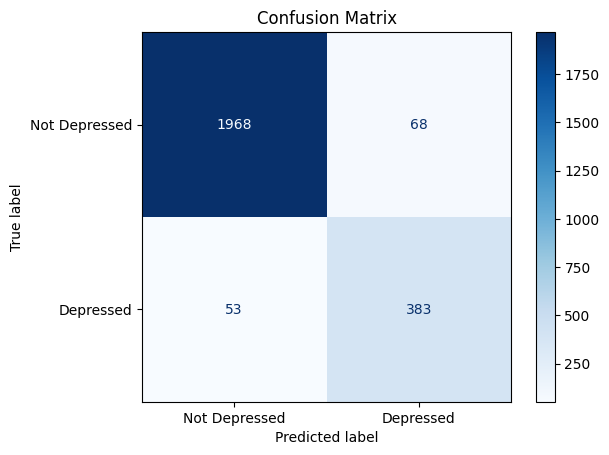

In [6]:
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, test_dataloader, class_names):
    model.eval()
    predictions, true_labels = [], []

    # Add progress bar to track progress through test_dataloader
    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Generating Predictions", leave=False):
            input_ids = batch['input_ids'].to('cuda')
            attention_mask = batch['attention_mask'].to('cuda')
            labels = batch['labels'].to('cuda')
            
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

# Example usage
class_names = ["Not Depressed", "Depressed"]  # Adjust class names to match your model’s output classes
plot_confusion_matrix(model, test_dataloader, class_names)


References

1. Salik I, Marwaha R. StatPearls [Internet]. StatPearls Publishing; Treasure Island (FL): Sep 19, 2022. Electroconvulsive Therapy.